In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
from pprint import pprint
import json

from transformers import AutoTokenizer, AutoModel, AutoConfig, pipeline
from datasets import load_dataset, Dataset, concatenate_datasets
import swifter

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-7b1")

### CNN_DAILY

In [ ]:
cnn = Dataset.from_json('../../data/translated/cnn_dailymail_30k_samples_len_100_1200_words_translated.json')

In [ ]:
input_template="Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] Tóm tắt ngắn gọn đoạn văn bản sau đây:\n{article_translated}\n[|AI|] "
def mapper(x):
    return {
        'input': input_template.format(article_translated=x['article_translated']),
        'output': 'Đoạn văn bản đã được tóm tắt:\n' + x['highlights_translated'] + '\n[|Con người|]'
    }

temp_cnn = cnn.shuffle().select(range(15000)).map(mapper,batched=False, remove_columns=['article_translated','highlights_translated'])

In [ ]:
print(temp_cnn[1]['input'] + temp_cnn[1]['output'])

In [ ]:
length = temp_cnn.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['input'] + x['output']))})
length.to_pandas().hist(bins=100)

In [ ]:
temp_cnn[0]

In [ ]:
temp_cnn.to_json('../../data/training_3_8/cnn_15k_samples.jsonl', orient='records', lines=True)

### DIALOG SUMMARY

In [ ]:
dialog = Dataset.from_json('../../data/translated/dialogsum_10k_samples_len_50_words_translated.json')

In [ ]:
dialog

In [ ]:
input_template="Tóm tắt ngắn gọn đoạn hội thoại sau đây:\n{dialogue_translated}\nĐoạn hội thoại đã được tóm tắt:\n"
def mapper(x):
    return {
        'input': input_template.format(dialogue_translated=x['dialogue_translated']),
        'output': x['summary_translated']
    }

temp_dialog = dialog.shuffle().select(range(10000)).map(mapper,batched=False, remove_columns=['dialogue_translated','summary_translated'])

In [ ]:
print(temp_dialog[1]['input'] + temp_dialog[1]['output'])

In [ ]:
temp_dialog[0]

In [ ]:
temp_dialog.to_json('../../data/training_3_8/dialogsum_10k_samples.jsonl', orient='records', lines=True)

### FAQS

In [4]:
from fuzzywuzzy import fuzz
faqs = Dataset.from_json('../../../data/training_31_7/faq_chat_10k.jsonl')
print(faqs.shuffle()[0]['input'])

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e90f1f489bc5a6e2/0.0.0)


Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây. Chỉ được trả lời dựa trên điều luật được cung cấp. Nếu không đủ thông tin để trả lời thì trả lời: Tôi không biết.
Câu hỏi: Quy trình lấy lời khai của đương sự như thế nào?
Điều luật liên quan: Điều 98. Lấy lời khai của đương sự 1. Thẩm phán chỉ tiến hành lấy lời khai của đương sự khi đương sự chưa có bản khai hoặc nội dung bản khai chưa đầy đủ, rõ ràng. Đương sự phải tự viết bản khai và ký tên của mình. Trường hợp đương sự không thể tự viết được thì Thẩm phán lấy lời khai của đương sự. Việc lấy lời khai của đương sự chỉ tập trung vào những tình tiết mà đương sự khai chưa đầy đủ, rõ ràng. Thẩm phán tự mình hoặc Thư ký Tòa án ghi lại lời khai của đương sự vào biên bản. Thẩm phán lấy lời khai của đương sự tại trụ sở Tòa án; trường hợp cần thiết có thể lấy lời khai của đương sự ngoài trụ sở Tòa án. 2. Biên bản ghi lời khai của đương sự phải được người khai tự đọc

In [5]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
text2 = ' Nếu không đủ thông tin để trả lời thì trả lời: Tôi không biết.'
text3 = 'Điều luật liên quan: '
text4 = ' Chỉ được trả lời dựa trên điều luật được cung cấp.'
def mapper(x):
    return {
        'input': text,
        'output': x['input'].removeprefix(text).replace(text2,'').replace(text3, 'Điều luật liên quan:\n').replace(text4, '') + '\n[|Con người|]',
    }

def mapper2(x):
    ai_index = x['output'].find('[|AI|]')
    return {
        'input': x['input'] + x['output'][:ai_index + 7],
        'output': x['output'][ai_index + 7:],
    }

temp_faqs = faqs.map(mapper, batched=False).map(mapper2, batched=False)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-e90f1f489bc5a6e2/0.0.0/cache-761db58758c19ad3.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-e90f1f489bc5a6e2/0.0.0/cache-a81d967f499143fb.arrow


In [6]:
temp_faqs_df = temp_faqs.to_pandas()
temp_faqs_df = temp_faqs_df.drop_duplicates(subset=['output']).reset_index(drop=True)
temp_faqs_df['length_input'] = temp_faqs_df['input'].apply(lambda x: len(tokenizer.tokenize(x)))
temp_faqs_df['length_output'] = temp_faqs_df['output'].apply(lambda x: len(tokenizer.tokenize(x)))
temp_faqs_df['similarity'] = temp_faqs_df.apply(lambda x: fuzz.ratio(x['input'], x['output']) / (x['length_input'] + x['length_output']), axis=1)
temp_faqs_df

,input,output,length_input,length_output,similarity
0,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định tại Điều 57 Bộ luật Hình sự 2015...,257,209,0.182403
1,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Giữa bạn và người bạn của mình đã giao kết hợp...,364,335,0.060086
2,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Căn cứ theo quy định tại Điều 51 Luật thi hành...,642,317,0.060480
3,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,1. Chơi tài xỉu có phải là đánh bạc? Tài xỉu l...,797,912,0.029257
4,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo Điều 472 Bộ Luật Dân Sự 2015 thì hợp đồng...,146,192,0.174556
...,...,...,...,...,...
2617,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Thời gian làm thêm giờ (hay còn gọi là giờ tăn...,513,514,0.081792
2618,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định Khoản 4 tại Điều 250 Bộ luật hìn...,1399,224,0.014171
2619,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Căn cứ khoản 3 Điều 111 Bộ luật Lao động 2019 ...,214,211,0.178824
2620,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,1. Đối tượng áp dụng Tái hòa nhập cộng đồng th...,723,439,0.038726


<AxesSubplot:>

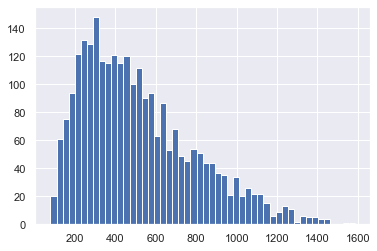

In [7]:
temp_faqs_df['length_input'].hist(bins=50)

<AxesSubplot:>

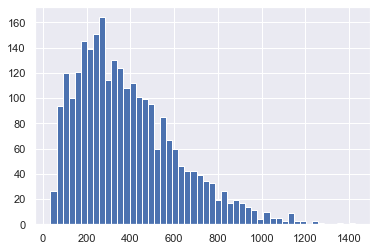

In [8]:
temp_faqs_df['length_output'].hist(bins=50)

<AxesSubplot:>

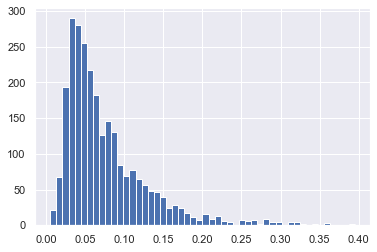

In [9]:
temp_faqs_df['similarity'].hist(bins=50)

In [10]:
temp_1 = temp_faqs_df[(temp_faqs_df['length_output'] <= 0.6 * temp_faqs_df['length_input']) & (temp_faqs_df['length_output'] <= 300) & (temp_faqs_df['similarity'] <= 0.07)].reset_index(drop=True)
temp_1

,input,output,length_input,length_output,similarity
0,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,"Hàng hóa luân chuyển trong quá trình sản xuất,...",825,274,0.030027
1,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Anh Tình đã xin cấp Giấy xác nhận tình trạng h...,430,172,0.069767
2,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định tại khoản 2 Điều 5 Nghị định số ...,432,230,0.057402
3,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo Điều 55 Luật Thi hành án dân sự 2008 quy ...,502,273,0.046452
4,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Căn cứ theo quy định tại Điều 3 Luật Thương mạ...,848,110,0.020877
...,...,...,...,...,...
411,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,"- Về nguyên tắc, khi nộp đơn yêu cầu ly hôn tạ...",545,159,0.042614
412,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Vì bạn là người Việt Nam định cư ở nước ngoài ...,520,228,0.069519
413,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định tại Điều 41 Nghị định số 22/2017...,588,259,0.066116
414,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định Khoản 4 tại Điều 250 Bộ luật hìn...,1399,224,0.014171


In [11]:
temp_faqs = Dataset.from_pandas(temp_1)
temp = temp_faqs.shuffle()[0]
print(temp['input'])
print(temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây.
Câu hỏi: Tôi và vợ tôi đi làm xa nhà. Chúng tôi muốn đăng ký kết hôn tại địa phương nơi làm việc có được không? Cần chuẩn bị những hồ sơ gì?
Điều luật liên quan:
Điều 17. Thẩm quyền đăng ký kết hôn 1. Ủy ban nhân dân cấp xã, nơi cư trú của bên nam hoặc bên nữ thực hiện việc đăng ký kết hôn. 2. Trong trường hợp cả hai bên nam, nữ là công dân Việt Nam đang trong thời hạn công tác, học tập, lao động ở nước ngoài về nước đăng ký kết hôn, đã cắt hộ khẩu thường trú ở trong nước, thì việc đăng ký kết hôn được thực hiện tại Ủy ban nhân dân cấp xã, nơi cư trú trước khi xuất cảnh của một trong hai bên nam, nữ.
Điều 8. Xác định thẩm quyền đăng ký hộ tịch 1. Đối với công dân Việt Nam ở trong nước, thì việc đăng ký hộ tịch được thực hiện tại nơi người đó đăng ký hộ khẩu thường trú; nếu không có nơi đăng ký hộ khẩu thường trú, thì việc đăng ký hộ tịch được thực hiện tại nơ

In [427]:
from random import choice

text = 'Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây.'
instruction_templates = {
    0: text,
    1: 'Giúp tôi trả lời câu hỏi pháp luật dựa vào những điều luật dưới đây.',
    2: 'Trả lời câu hỏi pháp luật sau đây.',
    3: 'Dựa vào những điều luật được cung cấp, hãy trả lời câu hỏi pháp luật sau đây.',
    4: 'Sau đây là những điều luật liên quan đến câu hỏi pháp luật. Hãy trả lời câu hỏi pháp luật sau đây.',
}

question_templates = {
    0: 'Câu hỏi pháp luật: ',
    1: 'Câu hỏi: ',
    2: '',
}

cite_templates = {
    0: 'Điều luật liên quan:',
    1: 'Điều luật:',
}
def mapper(x):
    a = choice([0,0,0,1,2,3,4])
    b = choice([0,0,0,1,1,1,2])
    c = choice([0,1])
    return {
        'input': x['input'].replace(text, instruction_templates[a]).replace('Câu hỏi: ', question_templates[b]).replace('Điều luật liên quan:', cite_templates[c]),
        'output': x['output']
    }

temp_faqs = temp_faqs.map(mapper, batched=False)

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

In [464]:
temp = temp_faqs.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Dựa vào những điều luật được cung cấp, hãy trả lời câu hỏi pháp luật sau đây.
Xử phạt hành vi buôn bán thiết bị y tế giả như thế nào?
Điều luật liên quan:
Điều 13. Hành vi buôn bán hàng giả mạo nhãn hàng hóa, bao bì hàng hóa 1. Đối với hành vi buôn bán hàng giả mạo nhãn hàng hóa, bao bì hàng hóa quy định tại điểm đ và e khoản 8 Điều 3 Nghị định này, mức phạt tiền như sau: a) Phạt tiền từ 200.000 đồng đến 500.000 đồng trong trường hợp hàng giả tương đương với số lượng của hàng thật có giá trị dưới 1.000.000 đồng; b) Phạt tiền từ 500.000 đồng đến 2.000.000 đồng trong trường hợp hàng giả tương đương với số lượng của hàng thật có giá trị từ 1.000.000 đồng đến dưới 3.000.000 đồng; c) Phạt tiền từ 2.000.000 đồng đến 3.000.000 đồng trong trường hợp hàng giả tương đương với số lượng của hàng thật có giá trị từ 3.000.000 đồng đến dưới 5.000.000 đồng; d) Phạt tiền từ 3.000.000 đồng đến 5.000.000 đồng trong trường hợp hàng giả tương đương

In [466]:
temp_faqs

Dataset({
    features: ['input', 'output', 'length_input', 'length_output', 'similarity'],
    num_rows: 416
})

In [467]:
temp_faqs.remove_columns(['length_input', 'length_output'])
temp_faqs.to_json('../../../data/training_21_8/faqs_400_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3155795

### SHARE_GPT

In [ ]:
share = pd.read_json('/Users/phamhoang1408/Desktop/Phase 2 Viettel/main_repo/data/original/share_gpt_no_code_conversations_40k.json', orient='records', lines=True)
share.columns = ['input']
share.dropna(inplace=True)
share.reset_index(drop=True, inplace=True)
share = Dataset.from_pandas(share)

In [ ]:
share = share.filter(lambda x: len(tokenizer.tokenize(x["input"])) < 2000)

In [ ]:
share.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['input']))}).to_pandas().hist(bins=100)

In [ ]:
# text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
text = 'The conversation between human and AI assistant.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['input'].removeprefix(text) + '\n[|Con người|]'
    }
share = share.map(mapper, batched=False)

In [ ]:
share

In [ ]:
share[0]

In [ ]:
share

In [ ]:
share.to_json('../../data/training_english/share_gpt_38k.jsonl', orient='records', lines=True)

### QUORA

In [8]:
quora = Dataset.from_json('../../../data/translated/quora_chat_data_translated.json')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-c3f1f507fe124413/0.0.0)


In [14]:
print(quora.shuffle()[0]['prompt'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Tôi đã tự hỏi, có thành viên nào của gia đình Medici còn sống đến ngày nay không?
[|AI|] Gia đình Medici là một gia đình ngân hàng và triều đại chính trị của Ý nổi bật trong thế kỷ 15 và 16. Còn về việc có con cháu nào còn sống hay không, hãy để tôi kiểm tra. Theo nguồn tin của tôi, ngày nay vẫn còn những hậu duệ còn sống của gia đình Medici. Tuy nhiên, họ không tích cực tham gia vào chính trị hay ngân hàng như tổ tiên của họ.
[|Con người|] Thú vị. Chuyện gì đã xảy ra với gia đình Medici?
[|AI|] Gia tộc Medici suy giảm quyền lực và ảnh hưởng sau thế kỷ 16, và vị vua cuối cùng của nhà Medici qua đời mà không có người thừa kế. Tài sản của gia đình sau đó đã được thu hút bởi bang Tuscany.
[|Con người|] Tệ quá. Gia đình Medici có đóng góp gì đáng kể cho lịch sử không?
[|AI|] Đúng vậy, gia đình Medici đã đóng một vai trò quan trọng trong thời kỳ Phục hưng, đưa vào vận hành các tác phẩm nghệ thuật và kiến ​​trúc nổi tiếng như David c

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

array([[<AxesSubplot:title={'center':'len'}>]], dtype=object)

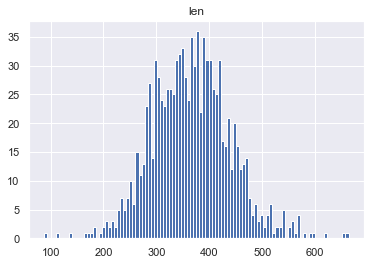

In [34]:
quora.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['prompt']))}).to_pandas().hist(bins=100)

In [35]:
temp_quora = quora.shuffle().select(range(20000))
temp_quora

Dataset({
    features: ['prompt'],
    num_rows: 20000
})

In [36]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['prompt'].removeprefix(text)
    }

temp_quora = temp_quora.map(mapper, batched=False, remove_columns=['prompt'])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [37]:
temp = temp_quora.shuffle()[0]
print(temp['input'])
print(temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.

[|Con người|] Tôi đã tự hỏi, bạn có nghĩ rằng một thế giới không có tiền sẽ tốt hơn không?
[|AI|] Là một trợ lý AI, tôi không có ý kiến ​​cá nhân, nhưng theo một số nhà kinh tế và triết học, một xã hội không có tiền có thể dẫn đến một thế giới bình đẳng và công bằng hơn. Tuy nhiên, nó cũng có thể đưa ra các vấn đề khác như phân bổ và phân phối tài nguyên.
[|Con người|] Hmm, thật thú vị. Bạn có nghĩ rằng mọi người sẽ vẫn có động lực làm việc nếu không có tiền?
[|AI|] Nếu không có tiền làm động lực, mọi người có thể bị thúc đẩy bởi những thứ khác nhau như hoàn thành mục tiêu cá nhân hoặc đóng góp cho xã hội. Thật khó để dự đoán động lực cá nhân sẽ thay đổi như thế nào trong một thế giới không có tiền.
[|Con người|] Tôi hiểu rồi. Còn những nhu cầu cơ bản như thức ăn và chỗ ở, làm thế nào để cung cấp những thứ đó nếu không có tiền?
[|AI|] Trong một xã hội không có tiền, các nguồn lực như thức ăn và chỗ ở có thể được phân phối dựa trên nhu cầu h

In [39]:
temp_quora.shuffle().select(range(5000)).to_json('../../../data/training_21_8/quora_5k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

14124197

### Oasst

In [4]:
oasst = Dataset.from_json('/Users/phamhoang1408/Desktop/Phase 2 Viettel/main_repo/data/translated/oasst_translated.json')
oasst = oasst.filter(lambda x: not ('```' in x['text'] or 'trăn' in x['text'] or "'''" in x['text']))
oasst

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-55de3ec8ff4a005a/0.0.0)
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-55de3ec8ff4a005a/0.0.0/cache-eb02a04fa2bb27f7.arrow


Dataset({
    features: ['text'],
    num_rows: 19168
})

In [5]:
temp_oasst2 = oasst.filter(lambda x: len(tokenizer.tokenize(x['text'])) > 100)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-55de3ec8ff4a005a/0.0.0/cache-42a30629df973077.arrow


In [ ]:
temp_oasst2

In [6]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['text'].removeprefix(text)
    }

temp_oasst = temp_oasst2.map(mapper, batched=False, remove_columns=['text'])

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-55de3ec8ff4a005a/0.0.0/cache-54bcf9ade1856bde.arrow


In [15]:
temp = temp_oasst.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Một số kỹ năng cần thiết mà một lập trình viên phải có là gì? (Rõ ràng là bên cạnh việc lập trình)
[|AI|] Về cơ bản, trở thành một lập trình viên bao gồm việc giải một câu đố mỗi ngày cùng với một nhóm người khác. Vì vậy, bạn có thể tưởng tượng rằng *** kỹ năng giao tiếp tốt *** thực sự quan trọng. Để tìm ra câu đố là gì, bạn cũng sẽ cần ***kỹ năng phân tích tốt*** để xem xét vấn đề ở một số góc độ khác nhau và quyết định cách hành động.
Thỉnh thoảng, bạn sẽ có những đồng nghiệp mới và sẽ phải ***huấn luyện đồng nghiệp của bạn*** để giúp họ bắt đầu hoặc giải thích giải pháp của bạn (hoặc nhóm) cho những người khác.

Đây là những yêu cầu phổ biến nhất đối với các nhà phát triển cơ sở mới.
[|Con người|] "đào tạo đồng nghiệp của bạn" ý bạn là "đào tạo đồng nghiệp của bạn"?
[|AI|] Chắc tôi đã mắc lỗi đánh máy. Cảm ơn bạn đã sửa lỗi cho tôi! Có bất cứ điều gì khác tôi có thể giúp với bạn với?


In [16]:
temp_oasst.shuffle().select(range(5000)).to_json('../../../data/training_21_8/oasst_5k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

18082816

In [ ]:
oasst.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['text']))}).to_pandas().hist(bins=100)

In [ ]:
print(temp_oasst.shuffle()[0])

In [ ]:
temp_oasst.to_json('../../data/training_3_8/oasst_20k_samples.jsonl', orient='records', lines=True)

### ALPACA CHAT

In [15]:
alpaca = Dataset.from_json('../../../data/translated/alpaca_chat_cleaned_51k_translated.json')
temp_df = alpaca.to_pandas()
temp_length = temp_df.apply(lambda x: len(tokenizer.tokenize(x['prompt'])), axis=1)

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e8795aa44813c1e9/0.0.0)


In [18]:
alpaca_temp = Dataset.from_pandas(temp_df[temp_length>=150].reset_index(drop=True))
alpaca_temp

Dataset({
    features: ['prompt'],
    num_rows: 14747
})

In [19]:
print(alpaca_temp.shuffle()[0]['prompt'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Đánh giá hiệu quả của một chiến dịch ảnh hưởng trực tuyến
[|AI|] Hiệu quả của một chiến dịch ảnh hưởng trực tuyến có thể được đánh giá bằng cách xem xét cả hai hiệu ứng ngắn hạn và dài hạn. Trong ngắn hạn, người ta có thể nhìn vào các số liệu như tầm với, ấn tượng, chuyển đổi và tham gia. Ngoài ra, điều quan trọng là phải xem xét tình cảm tổng thể của chiến dịch, cũng như phản ứng từ các đối tượng mục tiêu. Về lâu dài, người ta nên đánh giá tác động chung của chiến dịch, chẳng hạn như sự phát triển của nhận thức về thương hiệu, tăng cường danh tiếng của thương hiệu và số lượng trải nghiệm tích cực của khách hàng.
[|Con người|]


In [ ]:
def mapper(x):
    ai_index = x['prompt'].find('[|AI|]')
    return {
        'input': x['prompt'][:ai_index+7],
        'output': x['prompt'][ai_index + 7:]
    }
temp_alpaca = alpaca_temp.map(mapper, batched=False, remove_columns=alpaca.column_names)

In [ ]:
temp_alpaca.shuffle()[0]

In [ ]:
temp_alpaca.to_json('../../../data/training_14_8/alpaca_chat_26k_samples.jsonl', orient='records', lines=True)

### GPT4 INSTRUCT

In [50]:
gpt4 = Dataset.from_json('../../../data/translated/gpt4_instruct_similarity_0_9_translated.jsonl')
gpt4

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-53a1d8892b43af61/0.0.0)


Dataset({
    features: ['instruction_translated', 'input_translated', 'response_translated'],
    num_rows: 17873
})

In [53]:
template1 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction_translated}\n{input_translated}\n[|AI|] "
template2 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction_translated}\n[|AI|] "

def mapper(x):
    if x['input_translated'] != '' and x['input_translated'] is not None:
        template = template1.format(
            instruction_translated=x['instruction_translated'], 
            input_translated=x['input_translated']
        )
    else:
        template = template2.format(instruction_translated=x['instruction_translated'])
    return {
        'input': template,
        'output': x['response_translated'] + '\n[|Con người|]'
    }

temp_gpt4 = gpt4.map(mapper,batched=False, remove_columns=gpt4.column_names)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-53a1d8892b43af61/0.0.0/cache-27c0a5f7bf41c516.arrow


In [54]:
temp = temp_gpt4.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Viết lại đoạn văn sau với giọng điệu lịch sự và trang trọng hơn.
Này, bạn cần khắc phục vấn đề với địa chỉ giao hàng ngay bây giờ. Nó gây ra sự chậm trễ trong giao hàng đặt hàng của tôi.
[|AI|] Dear Sir/Madam, Tôi muốn yêu cầu sự hỗ trợ của bạn trong việc khắc phục vấn đề với địa chỉ giao hàng, vì nó dường như gây ra sự chậm trễ trong việc giao hàng cho đơn hàng của tôi. Cảm ơn.
[|Con người|]


In [98]:
a = temp_gpt4.shuffle()[0]
print(a['input']+a['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Giúp cải thiện câu sau trong một bài báo khoa học: 'Điều đáng chú ý là các nghiên cứu khác nhau đã chỉ ra rằng nước đóng vai trò chính trong quá trình tổng hợp các hợp chất hữu cơ quan trọng.'
[|AI|] Trong khuôn khổ một bài báo khoa học, có thể cải nghĩa câu như sau: 'Nhiều nghiên cứu đã chứng minh rằng nước đóng vai trò cốt yếu trong quá trình tổng hợp các chất thiết yếu. hợp chất hữu cơ.' Câu văn được sửa đổi ngắn gọn hơn, tránh dư thừa và sử dụng ngôn ngữ chính xác và học thuật hơn.
[|Con người|]


In [11]:
temp_gpt4.to_json('../../data/training_3_8/gpt4_instruct.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

26685705

### DOLLY WITH CONTEXT

In [269]:
dolly = Dataset.from_json('../../../data/translated/dolly_with_context_translated.jsonl')
# dolly = dolly.remove_columns(['instruction', 'context', 'response', 'category_translated'])

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e7046f43243de008/0.0.0)


In [270]:
temp = dolly.shuffle()[0]
print(temp['context_translated'])
print('----------')
print(temp['instruction_translated'])

Năng lượng hình thành tự do Gibbs tiêu chuẩn (Gf°) của một hợp chất là sự thay đổi năng lượng tự do Gibbs đi kèm với sự hình thành 1 mol chất ở trạng thái tiêu chuẩn từ các nguyên tố cấu thành của nó ở trạng thái tiêu chuẩn (dạng ổn định nhất của phần tử ở áp suất 1 bar và nhiệt độ quy định, thường là 298,15 K hoặc 25 °C).

Bảng dưới đây liệt kê hàm Gibbs tiêu chuẩn của sự hình thành một số nguyên tố và hợp chất hóa học và được lấy từ Sổ tay Hóa học của Lange. Lưu ý rằng tất cả các giá trị đều tính bằng kJ/mol. Các bảng mở rộng hơn có thể được tìm thấy trong Sổ tay Hóa học và Vật lý CRC và các bảng NIST JANAF. WebBook Hóa học của NIST (xem liên kết bên dưới) là một tài nguyên trực tuyến chứa entanpy tiêu chuẩn của sự hình thành cho các hợp chất khác nhau cùng với entropy tuyệt đối tiêu chuẩn cho các hợp chất này mà từ đó có thể tính được năng lượng hình thành tự do Gibbs tiêu chuẩn.
----------
Năng lượng tự do Gibbs tiêu chuẩn là gì


In [271]:
dolly.shuffle()[0]

{'instruction': 'Can you give me some background on Perez v. Campbell',
 'instruction_translated': 'Bạn có thể cho tôi biết thông tin cơ bản về vụ án Perez v. Campbell không',
 'context': "Perez v. Campbell, 402 U.S. 637 (1971), was a case in which the Supreme Court of the United States held that Arizona's law suspending a driver's license was unconstitutional due to its conflict with the federal Bankruptcy Act under the Supremacy Clause of the Constitution.\n\nBackground\nThe plaintiffs, Mr. Adolfo and Mrs. Emma Perez, were licensed uninsured motorists in the state of Arizona. Insurance was not required under Arizona law. Mr. Perez was involved in a traffic accident and, unable to pay the associated costs, soon filed for bankruptcy. Arizona, under its financial responsibility laws, withdrew the Perez' licenses, and the couple filed suit in district court, where their claim was denied. The Perez family's appeal to the United States Court of Appeals for the Ninth Circuit was denied, and

In [493]:
from random import choice

pretext = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] '
instruction_templates = [
    "Trả lời câu hỏi dựa vào đoạn văn bản dưới đây. Nếu không có thông tin trong đoạn văn bản thì trả lời: Tôi không biết.\nCâu hỏi: {instruction_translated}\nĐoạn văn bản:\n{context_translated}\n[|AI|] ",
    "Giúp tôi trả lời câu hỏi sau đây.\nCâu hỏi: {instruction_translated}\nĐoạn văn bản:\n{context_translated}\n[|AI|] ",
    "Sử dụng thông tin trong văn bản sau đây để trả lời câu hỏi.\nVăn bản:\n{context_translated}\nCâu hỏi: {instruction_translated}\n[|AI|] ",
    "Hãy trả lời câu hỏi sau sử dụng thông tin của đoạn văn bản được cung cấp, nếu không có thông tin thì phản hồi không trả lời được.\n{context_translated}\nCâu hỏi: {instruction_translated}\n[|AI|] ",
    "Trả lời câu hỏi sử dụng đoạn văn bản sau.\n{context_translated}\n{instruction_translated}\n[|AI|] ",
    "Đưa ra phản hồi cho câu hỏi sau đây, nếu không tìm thấy thông tin thì trả lời: Không có thông tin cho câu hỏi của bạn.\n{context_translated}\nCâu hỏi: {instruction_translated}\n[|AI|] ",
]

def mapper(x):
    ip = pretext + choice(instruction_templates).format(
        instruction_translated=x['instruction_translated'],
        context_translated=x['context_translated']
    )
    return {
        'input': ip,
        'output': choice([''] * 9 + ['Trả lời: ', 'Câu trả lời: ']) + x['response_translated'] + '\n[|Con người|]'
    }

temp_dolly = dolly.map(mapper,batched=False, remove_columns=dolly.column_names)

Map:   0%|          | 0/3903 [00:00<?, ? examples/s]

In [503]:
temp = temp_dolly.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Đưa ra phản hồi cho câu hỏi sau đây, nếu không tìm thấy thông tin thì trả lời: Không có thông tin cho câu hỏi của bạn.
Trò chơi lấy bối cảnh 200 năm sau các sự kiện của Oblivion, và diễn ra ở Skyrim, tỉnh cực bắc của Tamriel. Câu chuyện chính của nó tập trung vào nhân vật của người chơi, Dragonborn, trong nhiệm vụ đánh bại Alduin the World-Eater, một con rồng được tiên tri sẽ hủy diệt thế giới. Trong suốt trò chơi, người chơi hoàn thành các nhiệm vụ và phát triển nhân vật bằng cách cải thiện các kỹ năng. Trò chơi tiếp tục truyền thống thế giới mở của những người tiền nhiệm bằng cách cho phép người chơi du hành đến bất kỳ đâu trong thế giới trò chơi bất cứ lúc nào và bỏ qua hoặc hoãn cốt truyện chính vô thời hạn.
Câu hỏi: Skyrim là gì?
[|AI|] Skyrim là một trò chơi giả tưởng thời trung cổ dựa trên thế giới hư cấu của Tamriel. Với việc là trò chơi thứ năm trong loạt phim Elder Scrolls, nó có rất nhiều truyền thuyết để khai thác. 

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây. Chỉ được trả lời dựa trên thông tin nằm trong điều luật được cung cấp.
Câu hỏi: Phạm tội trong trạng thái tinh thần bị kích động mạnh bị xử lý thế nào?
Điều luật liên quan:
Điều 125. Tội giết người trong trạng thái tinh thần bị kích động mạnh 1. Người nào giết người trong trạng thái tinh thần bị kích động mạnh do hành vi trái pháp luật nghiêm trọng của nạn nhân đối với người đó hoặc đối với người thân thích của người đó, thì bị phạt tù từ 06 tháng đến 03 năm. 2. Phạm tội đối với 02 người trở lên, thì bị phạt tù từ 03 năm đến 07 năm.
[|AI|] Giết người trong trạng thái tinh thần bị kích động mạnh Tội giết người trong trạng thái tinh thần bị kích động mạnh được quy định tại Điều 125 Bộ luật Hình sự 2015 sửa đổi, bổ sung 2017 với mức hình phạt như sau: Khung 1: Người nào giết người trong trạng thái tinh thần bị kích động mạnh do hành vi trái pháp luật nghiêm trọng của nạn nhân đối với người đó hoặc đối với người thân thích của người đó, thì bị phạt tù từ 06 tháng đến 03 năm. Khung 2: Phạm tội đối với 02 người trở lên, thì bị phạt tù từ 03 năm đến 07 năm.
[|Con người|]

In [506]:
Dataset.from_pandas(temp_dolly.to_pandas().sample(5000, replace=True).reset_index(drop=True)).to_json('../../../data/training_21_8/dolly_4k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

16860651

### Role Play

In [ ]:
role = Dataset.from_json('../../../data/translated/roleplay_translated.jsonl')
role = Dataset.from_pandas(role.data.to_pandas().sample(5000, replace=True))

In [ ]:
template1 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction_translated}\n[|AI|] "
template2 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction_translated}\n{input_translated}\n[|AI|] "

def mapper(x):
    if x['input_translated'] == '':
        ip = template1.format(
            instruction_translated=x['instruction_translated'], 
        )
    else:
        ip = template2.format(
            instruction_translated=x['instruction_translated'], 
            input_translated=x['input_translated']
        )
    return {
        'input': ip,
        'output': x['output_translated'] + '\n[|Con người|]'
    }

temp_role = role.map(mapper,batched=False, remove_columns=role.column_names)

In [ ]:
temp_role

In [ ]:
temp = temp_role.shuffle()[0]
print(temp['input'] + temp['output'])

In [ ]:
temp_role.to_json('../../../data/training_14_8/role_play_3k_samples.jsonl', orient='records', lines=True)

### Orca

In [65]:
orca = Dataset.from_json('../../../data/translated/orca_translated_50k.jsonl')
orca = orca.remove_columns(['system_prompt','question','response'])

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-fd4c67cf1ae60254/0.0.0)


In [66]:
temp = orca.shuffle()[0]
print(temp['system_prompt_translated'])
print('------------------')
print(temp['question_translated'])
print('------------------')
print(temp['response_translated'])

Bạn là một trợ lý AI. Cung cấp câu trả lời chi tiết để người dùng không cần tìm kiếm bên ngoài để hiểu câu trả lời.
------------------
Bài báo: Nếu bạn đến Ai Cập, bạn sẽ thấy rất nhiều kim tự tháp. Lớn nhất trong số đó là Kim tự tháp vĩ đại. Nó cao khoảng 137 mét và được làm bằng 2.300.000 tảng đá lớn. Mỗi tảng đá nặng khoảng hai tấn rưỡi. Những tảng to nhất thậm chí nặng tới mười lăm tấn. Phải mất hơn 100.000 người đàn ông trong hai mươi năm để xây dựng nó. Không ai có thể biết những người đàn ông đã cắt, khuân vác và nâng những tảng đá khổng lồ như thế nào nếu không có máy móc hiện đại của chúng tôi. Các vị vua Ai Cập bảo người dân xây dựng các kim tự tháp cho chính họ. Họ nghĩ rằng họ có những ngôi mộ đủ chắc chắn để giữ cho cơ thể họ khỏe mạnh cho đến khi họ sống lại. Nhưng họ không bao giờ nghĩ rằng khoảng 5.000 năm sau, xác của họ sẽ được trưng bày trong viện bảo tàng. Câu hỏi: Kim tự tháp được xây dựng cho _ . Có hay không, câu trả lời là "các vị vua"?
Trả lời:
----------------

In [67]:
template1 = "{system_prompt}\n[|Con người|] {question}\n[|AI|] "
template2 = "[|Con người|] {question}\n[|AI|] "

def mapper(x):
    if x['system_prompt_translated'] == '':
        ip = template2.format(
            question=x['question_translated'],
        )
    else:
        ip = template1.format(
            system_prompt=x['system_prompt_translated'],
            question=x['question_translated'],
        )
    return {
        'input': ip,
        'output': x['response_translated'] + '\n[|Con người|]',
    }

temp_orca = orca.map(mapper, remove_columns=orca.column_names)


Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-fd4c67cf1ae60254/0.0.0/cache-7e0fe43ec263249c.arrow


In [68]:
temp = temp_orca.shuffle()[0]
print(temp['input'] + temp['output'])

Bạn là một trợ lý AI. Người dùng sẽ cung cấp cho bạn một nhiệm vụ. Mục tiêu của bạn là hoàn thành nhiệm vụ một cách trung thực nhất có thể. Trong khi thực hiện nhiệm vụ, hãy suy nghĩ từng bước một và biện minh cho các bước của bạn.
[|Con người|] Vui lòng trả lời câu hỏi sau: Tôi biết rằng câu trả lời cho câu hỏi "Điều gì đã xảy ra sau cuộc Thập tự chinh đầu tiên?" nằm trong "Các cuộc thập tự chinh nhằm chiếm Jerusalem từ sự kiểm soát của người Hồi giáo. Cuộc Thập tự chinh đầu tiên được Giáo hoàng Urban II (giáo hoàng 1088–99) tuyên bố tại Hội đồng Clermont năm 1095 theo yêu cầu của Hoàng đế Byzantine Alexios I Komnenos (r . 1081–1118) để được hỗ trợ chống lại những bước tiến xa hơn của người Hồi giáo. Thành thị hứa hẹn sẽ ban ơn cho bất kỳ ai tham gia. Hàng chục nghìn người từ mọi tầng lớp xã hội đã huy động khắp châu Âu và chiếm được Jerusalem vào năm 1099. Một đặc điểm của các cuộc thập tự chinh là các cuộc tàn sát chống lại người dân địa phương Những người Do Thái thường diễn ra khi

In [69]:
temp_orca.shuffle().select(range(25000)).to_json('../../../data/training_21_8/orca_25k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

103812133

### Wivi

In [20]:
wivi = Dataset.from_json('../../../data/translated/wizard_vicuna_nocode_translated.jsonl')
wivi = wivi.select_columns(['conversations_translated'])
wivi = wivi.rename_column('conversations_translated', 'conversation')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-0c4936edc7eb99aa/0.0.0)


In [22]:
wivi[0]['conversation']

'[|Con người|] Liệt kê những ưu và nhược điểm của việc sử dụng ô tô điện kết hợp với các nguồn năng lượng tái tạo để giảm thiểu lượng khí thải carbon.\n[|AI|] Ưu điểm của việc sử dụng ô tô điện kết hợp với các nguồn năng lượng tái tạo:\n1. Giảm lượng khí thải carbon: Ô tô điện không tạo ra khí thải, điều đó có nghĩa là chúng có thể giảm đáng kể lượng khí thải carbon khi được cung cấp bởi các nguồn năng lượng tái tạo.\n2. Tiết kiệm năng lượng: Ô tô điện tiết kiệm năng lượng hơn so với các phương tiện sử dụng động cơ đốt trong truyền thống, có nghĩa là chúng cần ít năng lượng hơn để di chuyển trên cùng một quãng đường.\n3. Giảm sự phụ thuộc vào nhiên liệu hóa thạch: Ô tô điện chạy bằng các nguồn năng lượng tái tạo có thể giảm sự phụ thuộc vào nhiên liệu hóa thạch, vốn là hữu hạn và góp phần gây ra biến đổi khí hậu.\n4. Chi phí vận hành thấp hơn: Ô tô điện có chi phí vận hành thấp hơn so với các loại xe động cơ đốt trong truyền thống, vì chúng cần ít bảo trì hơn và điện rẻ hơn xăng.\nNhượ

In [23]:
text = "Cuộc trò chuyện giữa con người và trợ lý AI.\n"
def mapper(x):
    return {
        'input': text,
        'output': x['conversation'].removeprefix(text) + '\n[|Con người|]'
    }

temp_wivi = wivi.map(mapper, batched=False, remove_columns=wivi.column_names)

Map:   0%|          | 0/30527 [00:00<?, ? examples/s]

In [30]:
temp = temp_wivi.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Sử dụng danh sách 1000 từ khó hiểu được cung cấp, hãy xây dựng một truy vấn gợi ra thông tin về trải nghiệm hoặc kiến ​​thức cá nhân của cá nhân liên quan đến một thuật ngữ được chọn ngẫu nhiên. Truy vấn phải được diễn đạt dưới dạng câu hỏi trắc nghiệm với bốn câu trả lời có thể có, mỗi câu trả lời phải được viết bằng tiếng Latinh. Ngoài ra, cá nhân đó phải cung cấp một lời giải thích ngắn gọn bằng văn bản về lý do đằng sau câu trả lời đã chọn của họ, sử dụng định dạng trích dẫn MLA thích hợp. Thuật ngữ được chọn là "floccinaucinihilipilification."
[|AI|] Cụm từ tiếng Latinh nào sau đây mô tả đúng nhất sự quen thuộc của bạn với thuật ngữ "floccinaucinihilipilification"?
A) "Ignorantia legis neminem excusat" (Sự thiếu hiểu biết về luật pháp không bào chữa cho ai)
B) "Deus ex machina" (Chúa từ cỗ máy)
C) "Carpe diem" (Nắm bắt cơ hội)
D) "Ad buồn nôn" (Đến mức buồn nôn)
Tôi hỏi điều này bởi vì "floccinaucinihilipilification" là mộ

In [31]:
temp_wivi.to_json('../../../data/training_21_8/wivi_30k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/31 [00:00<?, ?ba/s]

275319349

### Conversation query generation

In [3]:
data_path = [
    "../../../data/translated/retrieve_query_gen_oasst_translated.jsonl", 
    "../../../data/translated/retrieve_query_gen_quora_translated.jsonl", 
    "../../../data/translated/retrieve_query_gen_sharegpt_translated.jsonl",
]
query = concatenate_datasets([Dataset.from_json(path) for path in data_path])
temp = query.to_pandas().drop_duplicates(subset=['conversation']).sample(500, replace=True)
query = Dataset.from_pandas(temp.reset_index(drop=True))

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-3ecfe4735495290c/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-0bad7c81935852e3/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-63a04f4664c48905/0.0.0)


In [4]:
query

Dataset({
    features: ['conversation', 'conversation_translated', 'query', 'query_translated'],
    num_rows: 500
})

In [7]:
str("Hello from hoang").find("hoang")

11

In [5]:
template1 = "Dưới đây là đoạn hội thoại giữa con người và AI, cuối đoạn hội thoại là câu hỏi mới người dùng đặt ra cần được trả lời bằng cách tìm kiếm thông tin nằm trong cơ sở tri thức chung. Hãy sinh ra câu truy vấn phù hợp với đoạn hội thoại và câu hỏi mới của người dùng.\nĐoạn hội thoại:\n{conversation}\nCâu truy vấn: "

def mapper(x):
    ip = template1.format(
        conversation=x['conversation_translated'], 
    )
    return {
        'input': ip,
        'output': x['query_translated']
    }

temp_query = query.map(mapper,batched=False, remove_columns=query.column_names)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [7]:
temp = temp_query.shuffle()[0]
print(temp['input'])
print(temp['output'])

Dưới đây là đoạn hội thoại giữa con người và AI, cuối đoạn hội thoại là câu hỏi mới người dùng đặt ra cần được trả lời bằng cách tìm kiếm thông tin nằm trong cơ sở tri thức chung. Hãy sinh ra câu truy vấn phù hợp với đoạn hội thoại và câu hỏi mới của người dùng.
Đoạn hội thoại:
[|Con người|] Tôi muốn biết liệu bạn có thể cho tôi biết cách nhập cư hợp pháp vào Mỹ từ Paraguay không.
[|AI|] Chắc chắn rồi. Để nhập cư hợp pháp vào Hoa Kỳ từ Paraguay, bạn sẽ cần phải xin thị thực. Có một số loại thị thực khác nhau có sẵn, mỗi loại có yêu cầu đủ điều kiện riêng.
[|Con người|] Một số loại thị thực khác nhau là gì?
[|AI|] Một số loại thị thực phổ biến nhất là thị thực lao động, thị thực sinh viên và thị thực diện gia đình. Bạn muốn biết thêm thông tin về cái nào?
[|Con người|] Còn visa lao động thì sao? Các yêu cầu cho điều đó là gì?
[|AI|] Để có được thị thực lao động, bạn cần có lời mời làm việc từ một chủ lao động Hoa Kỳ sẵn sàng tài trợ cho đơn xin thị thực của bạn. Bạn cũng sẽ cần đáp ứng 

In [54]:
temp_query.to_json('../../../data/training_14_8/query_gen_500_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2041567

### Wizard

In [36]:
wizard = Dataset.from_json('../../../data/translated/wizard_no_code_translated.jsonl')
wizard

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-4033f5046678def4/0.0.0)


Dataset({
    features: ['idx', 'idx_translated', 'conversations', 'conversations_translated'],
    num_rows: 82130
})

In [39]:
temp = wizard.shuffle()[0]
print(temp['conversations_translated'])

[|Con người|] Là một giáo viên toán tiểu học, được giao nhiệm vụ giảng dạy mô-đun "số thập phân", vui lòng kết hợp sáu cấp độ nhận thức của Bloom, đó là ghi nhớ, hiểu, ứng dụng, phân tích, đánh giá và sáng tạo - và ngoài ra, bao gồm một hạn chế mà các kế hoạch bài học phải kết hợp các thao tác. Ngoài ra, hãy đưa ra một quy tắc rằng các mục tiêu học tập phải được điều chỉnh để đáp ứng nhu cầu cụ thể của từng học sinh. Vui lòng liệt kê hai mục tiêu học tập cho từng cấp độ của thang phân loại Bloom đáp ứng nhu cầu của mọi học sinh.
[|AI|] Cấp độ 1: Ghi nhớ
1. HS nhớ lại định nghĩa số thập phân.
2. Học sinh có thể xác định các giá trị vị trí của số thập phân.

Cấp độ 2: Hiểu biết
1. Học sinh giải thích được mối quan hệ giữa phân số và số thập phân.
2. Học sinh sẽ có thể phân biệt giữa hàng chục và hàng trăm.

Cấp độ 3: Áp dụng
1. Học sinh biết chuyển đổi số thập phân thành phân số.
2. Học sinh có thể giải các bài toán đố liên quan đến số thập phân.

Cấp độ 4: Phân tích
1. Học sinh biết so 

In [40]:
text = "Cuộc trò chuyện giữa con người và trợ lý AI.\n"
def mapper(x):
    index = x['conversations_translated'].find('[|AI|]')
    return {
        'input': text + x['conversations_translated'][:index+7],
        'output': x['conversations_translated'][index+7:] + '\n[|Con người|]'
    }

temp_wizard = wizard.map(mapper)

Map:   0%|          | 0/82130 [00:00<?, ? examples/s]

In [63]:
temp = temp_wizard.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Bằng cách nào việc sử dụng các từ tượng thanh có thể tăng cường mô tả về các loại động cơ phương tiện khác nhau? Cung cấp ba ví dụ về từ tượng thanh có thể được sử dụng để mô tả âm thanh của động cơ ô tô và giải thích cách mỗi từ thay đổi nhận thức về sức mạnh và tốc độ của động cơ. Ngoài ra, hãy xem xét tác động của tuổi thọ và bảo dưỡng của động cơ đối với âm thanh mà động cơ tạo ra và điều này có thể ảnh hưởng như thế nào đến nhận thức về hiệu suất của động cơ. Cuối cùng, thảo luận xem loại nhiên liệu mà động cơ sử dụng cũng có thể ảnh hưởng như thế nào đến âm thanh và hiệu suất của nó, đồng thời cung cấp các ví dụ về các loại nhiên liệu cụ thể và âm thanh động cơ tương ứng của chúng.
[|AI|] Các từ tượng thanh có thể rất hiệu quả trong việc nâng cao khả năng mô tả các loại động cơ phương tiện khác nhau vì chúng có thể giúp tạo ra trải nghiệm sống động và đắm chìm cho người đọc hoặc người nghe. Dưới đây là ba ví dụ về từ tượn

In [64]:
temp_wizard.shuffle().select(range(40000)).to_json('../../../data/training_21_8/wizard_30k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/40 [00:00<?, ?ba/s]

436331450

### Okapi

In [4]:
code_ocapi = Dataset.from_json('/Users/phamhoang1408/Desktop/Phase 2 Viettel/main_repo/data/original/okapi/code_related_okapi.jsonl')
no_code_ocapi = Dataset.from_json('/Users/phamhoang1408/Desktop/Phase 2 Viettel/main_repo/data/original/okapi/okapi_instruct_vi.json')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-a3435500b4bea6d2/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-794bec094f7dc439/0.0.0)


In [5]:
template1 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction}\n{input}\n[|AI|] "
template2 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction}\n[|AI|] "

def mapper(x):
    if x['input'] == '':
        ip = template2.format(
            instruction=x['instruction'],
        )
    else:
        ip = template1.format(
            instruction=x['instruction'],
            input=x['input']
        )
    return {
        'input': ip,
        'output': x['output'] + '\n[|Con người|]'
    }

temp_code_ocapi = code_ocapi.map(mapper, remove_columns=code_ocapi.column_names)    
temp_no_code_ocapi = no_code_ocapi.map(mapper, remove_columns=no_code_ocapi.column_names)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-a3435500b4bea6d2/0.0.0/cache-b6e38a2dc9c6e8b7.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-794bec094f7dc439/0.0.0/cache-296c168de6e841a0.arrow


In [117]:
temp_code_ocapi.to_json('../../../data/training_21_8/code_related_ocapi_6k_samples.jsonl', orient='records', lines=True)
temp_no_code_ocapi.shuffle().select(range(30000)).to_json('../../../data/training_21_8/no_code_ocapi_30k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

27601457

In [35]:
temp = temp_no_code_ocapi.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Tạo một bản rap về đội bóng rổ yêu thích của bạn.
Los Angeles Lakers
[|AI|] Dĩ nhiên đó là Los Angeles Lakers,
Xoay như chong chóng trên sân, không cần thiện ác.
Kobe và Shaq đã kiểm soát mọi trận đấu,
Vô địch và làm các fan phấn khích đầy háo hức - Wow!
Thống trị dưới rổ, vị trí phòng ngự,
Lakers chơi đúng bài và nó chính là sự xuất chúng.
LeBron và AD đang làm nóng từng giây,
Ai cũng biết Lakers sẽ chiến thắng không ngừng nghỉ!
Từ Staples Center tới phía bên kia thành phố,
Lakers giơ cao đầu, không thấy một phút giây lụi tàn.
Những pha dunk đến từ các công phá, không thể bị khuất phục,
Chính vì thế, Lakers là bá chủ và làm nên tên tuổi nên gọi là cả một trỗi junk!
[|Con người|]


### MMLU

In [813]:
mmlu_test = Dataset.from_json('../../../data/translated/mmlu/zero_shot_mmlu_chat_test_translated.jsonl')
mmlu_val = Dataset.from_json('../../../data/translated/mmlu/zero_shot_mmlu_chat_val_translated.jsonl')
print(len(mmlu_test), len(mmlu_val))
def mapper(x):
    return {
        'input': x['input_translated'] + "\n[|AI|] ",
        'output': x['output_translated'].removeprefix("[|AI|] ").replace("[|Human|]", "[|Con người|]")
    }
def filter(x):
    for a in ['A.', 'B.', 'C.', 'D.']:
        if not a in x['input']:
            return False
    for a in ['A\n[|Con người|]', 'B\n[|Con người|]', 'C\n[|Con người|]', 'D\n[|Con người|]']:
        if a in x['output']:
            return True
mmlu_val = mmlu_val.map(mapper).filter(filter)
mmlu_test = mmlu_test.map(mapper).filter(filter)
print(len(mmlu_test), len(mmlu_val))

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-9e7d5a55888ae4e6/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-64286f570b39b0e2/0.0.0)
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-64286f570b39b0e2/0.0.0/cache-a92a797c3a3af126.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-64286f570b39b0e2/0.0.0/cache-205d6dedf0d6e47f.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-9e7d5a55888ae4e6/0.0.0/cache-822cec9be5aac579.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-9e7d5a55888ae4e6/0.0.0/cache-b5d11864f48c6f0f.arrow


14042 1531


In [816]:
temp = mmlu_test.shuffle()[0]
print(temp['input'] + temp['output'])

Đoạn hội thoại giữa con người và trợ lý AI.
[|Con người|] Sau đây là các câu hỏi trắc nghiệm (có đáp án) về nghề luật.

Tại một khu vực tài phán sử dụng các chỉ số của người được cấp người được cấp, các sự kiện sau đây đã xảy ra theo thứ tự được liệt kê bên dưới: (1) Năm 1993, một người phụ nữ đã thế chấp một mảnh đất cho một công ty thế chấp để đảm bảo một khoản nợ trị giá 25.000 đô la, đáo hạn vào ngày 31 tháng 12 , 1993, với lãi suất 9'/2% mỗi năm. (2) Năm 1996, công ty thế chấp ghi nhận thế chấp trên thửa đất. (3) Năm 2007, trong một tờ giấy có chữ ký mà người phụ nữ giao cho con gái, người phụ nữ này hứa sẽ chuyển nhượng mảnh đất cho con gái bằng văn bản nhượng quyền và trả nợ khi đến hạn. (4) Vào năm 2008, người phụ nữ đã giao cho con gái một chứng thư từ bỏ quyền sở hữu không đề cập đến khoản thế chấp. Nếu người phụ nữ sau đó không trả được nợ thế chấp, điều nào sau đây có thể đúng?
A. Chỉ có con gái mới có nguyên nhân hành động chống lại người phụ nữ.
B. Chỉ có công ty cho vay 

In [817]:
mmlu_val.to_json('../../../data/training_21_8/eval_test/mmlu_zeroshot_val.jsonl', orient='records', lines=True)
mmlu_test.to_json('../../../data/training_21_8/eval_test/mmlu_zeroshot_test.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

36119070

### Squad V2 (No answer)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /Users/phamhoang1408/.cache/huggingface/datasets/json/default-d012ad3e708b755d/0.0.0. Subsequent calls will reuse this data.


In [482]:
from random import choice
squadv2 = Dataset.from_json('../../../data/translated/squad2_no_ans_translated.jsonl').shuffle().select(range(1500))


pre_text = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] "

prompts1 = [
    'Hãy trả lời câu hỏi sau\n{question}\nThông tin:\n{context}',
    'Phản hồi lại câu hỏi sau đây sử dụng thông tin trong đoạn văn bản.\nVăn bản:\n{context}\nCâu hỏi: {question}',
    "{context}\nCâu hỏi: {question}",
    'Trả lời câu hỏi dựa vào đoạn văn bản sau đây.\nĐoạn văn bản:\n{context}\nCâu hỏi:\n{question}',
    'Trả lời câu hỏi sau đây, chỉ sử dụng thông tin nằm trong đoạn văn bản.\nĐoạn văn bản:\n{context}\n{question}',
    'Sử dụng thông tin trong đoạn trích để trả lời câu hỏi sau:\n{question}\nĐoạn trích:\n{context}',
]

prompts2 = [
    ["Trả lời câu hỏi dựa vào thông tin trong đoạn văn bản sau đây. Nếu không tìm thấy thống tin nằm trong đoạn văn bản thì trả lời: Không có thông tin cho câu hỏi của bạn.\n{context}\nCâu hỏi: {question}\n[|AI|] ", "Không có thông tin cho câu hỏi của bạn.\n[|Con người|]"],
    ["Sử dụng thông tin trong đoạn văn bản sau đây để trả lời câu hỏi. Nếu không tìm thấy thống tin nằm trong đoạn văn bản thì trả lời: Không có thông tin cho câu hỏi của bạn.\nCâu hỏi: {question}\nĐoạn văn bản:\n{context}\n[|AI|] ", "Không có thông tin cho câu hỏi của bạn.\n[|Con người|]"],
    ["Sử dụng đoạn trích sau đây để trả lời, nếu không có thông tin thì phản hồi không trả lời được.\n{context}\nCâu hỏi: {question}\n[|AI|] ","Xin lỗi, tôi không có câu trả lời cho câu hỏi của bạn.\n[|Con người|]"],
    ["Hãy trả lời câu hỏi sau đây, nếu không có thông tin thì trả lời không trả lời được.\nVăn bản:\n{context}\n{question}\n[|AI|] ","Xin lỗi, tôi không trả lời được câu hỏi này.\n[|Con người|]"],
]
    
no_answers = [
    "Xin lỗi, tôi không có thông tin cho câu hỏi của bạn.\n[|Con người|]",
    "Tôi không có câu trả lời cho câu hỏi này.\n[|Con người|]",
    "Xin lỗi bạn, tôi không có câu trả lời.\n[|Con người|]",
    "Không có câu trả lời cho câu hỏi của bạn.\n[|Con người|]",
    "Xin lỗi, tôi không thể trả lời câu hỏi này.\n[|Con người|]",
]
def mapper1(x):
    return {
        'input': (pre_text + choice(prompts1) + "\n[|AI|] ").format(question=x['question_translated'], context=x['context_translated']),
        'output': choice(no_answers)
    }

def mapper2(x):
    c = choice(prompts2)
    return {
        'input': (pre_text + c[0]).format(question=x['question_translated'], context=x['context_translated']),
        'output': c[1]
    }


temp = squadv2.train_test_split(test_size=0.5, seed=42)
final_1 = temp['train'].map(mapper1, remove_columns=squadv2.column_names)
final_2 = temp['test'].map(mapper2, remove_columns=squadv2.column_names)
print(final_1, final_2)

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-d012ad3e708b755d/0.0.0)


Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'output'],
    num_rows: 750
}) Dataset({
    features: ['input', 'output'],
    num_rows: 750
})


In [483]:
temp = final_1.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi sau đây, chỉ sử dụng thông tin nằm trong đoạn văn bản.
Đoạn văn bản:
Ý nghĩa của chủ nghĩa liên bang, với tư cách là một phong trào chính trị, và những gì tạo nên một 'liên bang', thay đổi tùy theo quốc gia và bối cảnh lịch sử. [cần dẫn nguồn] Các phong trào liên quan đến việc thành lập hoặc phát triển các liên đoàn có thể thể hiện xu hướng tập trung hóa hoặc phi tập trung hóa.[ cần dẫn nguồn] Ví dụ, vào thời điểm các quốc gia đó được thành lập, các phe phái được gọi là "những người theo chủ nghĩa liên bang" ở Hoa Kỳ và Úc chủ trương thành lập chính quyền trung ương mạnh mẽ. Tương tự như vậy, trong nền chính trị của Liên minh châu Âu, những người theo chủ nghĩa liên bang chủ yếu tìm kiếm sự hội nhập sâu rộng hơn vào EU. Ngược lại, ở Tây Ban Nha và Đức thời hậu chiến, các phong trào liên bang đã tìm kiếm sự phân cấp: chuyển giao quyền lực từ chính quyền trung ương đến các đơn vị địa phương. Ở Canada, nơi chủ nghĩ

In [484]:
temp = final_2.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Sử dụng thông tin trong đoạn văn bản sau đây để trả lời câu hỏi. Nếu không tìm thấy thống tin nằm trong đoạn văn bản thì trả lời: Không có thông tin cho câu hỏi của bạn.
Câu hỏi: Tôn giáo Tin lành nào cởi mở để nói chuyện với người ngoài?
Đoạn văn bản:
Nhân chứng Giê-hô-va tin rằng Kinh thánh lên án sự pha trộn giữa các tôn giáo, trên cơ sở rằng chỉ có thể có một lẽ thật từ Đức Chúa Trời, và do đó bác bỏ các phong trào liên tôn và đại kết. Họ tin rằng chỉ có tôn giáo của họ đại diện cho Cơ đốc giáo chân chính, còn các tôn giáo khác không đáp ứng được mọi yêu cầu do Đức Chúa Trời đặt ra và sẽ sớm bị tiêu diệt. Nhân Chứng Giê-hô-va được dạy rằng điều quan trọng là phải “tách biệt khỏi thế gian”. Văn học của Nhân Chứng định nghĩa "thế giới" là "khối nhân loại ngoại trừ những tôi tớ được Đức Giê-hô-va chấp thuận" và dạy rằng thế giới bị Sa-tan làm ô uế và cai trị về mặt đạo đức. Các nhân chứng được dạy rằng việc kết giao với những 

In [485]:
final = concatenate_datasets([final_1, final_2])
final.to_json('../../../data/training_21_8/squadv2_no_ans_2000_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

4054534

In [216]:
temp = final.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi dựa vào thông tin trong đoạn văn bản sau đây. Nếu không tìm thấy thống tin nằm trong đoạn văn bản thì trả lời: Không có thông tin cho câu hỏi của bạn.
Trong số những đóng góp của ông cho triết học là tuyên bố của ông đã giải quyết được vấn đề triết học về quy nạp. Ông nói rằng mặc dù không có cách nào để chứng minh rằng mặt trời sẽ mọc, nhưng có thể xây dựng lý thuyết rằng mặt trời sẽ mọc mỗi ngày; nếu nó không tăng vào một ngày cụ thể nào đó, lý thuyết này sẽ bị sai lệch và sẽ phải được thay thế bằng một lý thuyết khác. Cho đến ngày đó, không cần phải bác bỏ giả định rằng lý thuyết này là đúng. Theo Popper, cũng không hợp lý khi đưa ra giả định phức tạp hơn rằng mặt trời sẽ mọc cho đến một ngày nhất định, nhưng sẽ ngừng làm như vậy vào ngày hôm sau, hoặc những tuyên bố tương tự với các điều kiện bổ sung.
Câu hỏi: Ai chưa từng tuyên bố đã giải được bài toán triết học về quy nạp?
[|AI|] Không có thông tin cho câu

### Query topic

In [241]:
topic_names = ["văn hoá xã hội", "toán và khoa học", "sức khoẻ", "tư vấn và giáo dục", "máy tính và internet", "thể thao", "kinh doanh và kinh tế", "âm nhạc và giải trí", "gia đình và các mối quan hệ", "pháp luật"]

topic_map = {
    str(k): v for k, v in zip(range(len(topic_names)), topic_names)
}
topic = Dataset.from_json('../../../data/translated/query_topic_translated.jsonl')
topic_df = topic.to_pandas()
topic_df = topic_df[topic_df['topic'].apply(lambda x: x != '9')]
topic_df['topic_name'] = topic_df['topic'].apply(lambda x: topic_map[x])
topic = Dataset.from_pandas(topic_df).select_columns(['topic_name', 'question_translated']).rename_column('question_translated', 'question').shuffle().select(range(3250))

faqs = Dataset.from_json('../../../data/translated/all_faqs.json')
def mapper(x):
    i = x['input'].find('\nĐiều luật liên quan: ')
    return {
        'question': x['input'][:i].removeprefix('Câu hỏi: '),
        'topic_name': 'pháp luật'
    }
faqs = faqs.map(mapper, remove_columns=faqs.column_names)
faqs = faqs.shuffle().select(range(750))

topic = concatenate_datasets([topic, faqs]).shuffle()

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-97c72fccf46cefdf/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-c757bbc3477ebaf6/0.0.0)
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-c757bbc3477ebaf6/0.0.0/cache-f2c664b3fd7b848b.arrow


<AxesSubplot:>

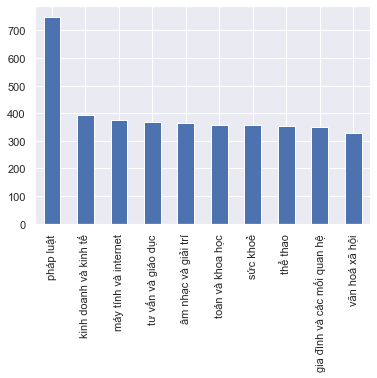

In [242]:
topic.to_pandas()['topic_name'].value_counts().plot(kind='bar')

In [243]:
topic

Dataset({
    features: ['topic_name', 'question'],
    num_rows: 4000
})

In [252]:
from random import choice
pretext = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] "
type1_input_prompts = [
    "Cho biết câu hỏi sau thuộc chủ đề nào?\n{question}\n[|AI|] ",
    "Câu hỏi sau đây thuộc chủ đề nào?\n{question}\n[|AI|] ",
    "Sau đây là một câu hỏi, hãy cho biết nó thuộc chủ đề nào?\nCâu hỏi: {question}\n[|AI|] ",
    "\nHỏi: {question}\nCâu hỏi trên thuộc chủ đề nào?\n[|AI|] ",
    "\n{question}\nChủ đề của câu hỏi trên là gì?\n[|AI|] ",
    "Giúp tôi xác định chủ đề của câu hỏi sau:\n{question}\n[|AI|] ",
]
type1_output_prompts = [
    "Câu hỏi này thuộc chủ đề {topic_name}.\n[|Con người|]",
    "{topic_name}.\n[|Con người|]",
    "Chủ đề của câu hỏi này là {topic_name}.\n[|Con người|]",
]    

def type1_prompt(x):
    return {
        'input': (pretext + choice(type1_input_prompts)).format(question=x['question']),
        'output': choice(type1_output_prompts).format(topic_name=x['topic_name'])
    }

type2_input_prompts = [
    "Câu hỏi sau đây có thuộc chủ đề {topic_name} không?\nCâu hỏi: {question}\n[|AI|] ",
    "Đây có phải là câu hỏi thuộc chủ đề {topic_name} không?\n{question}\n[|AI|] ",
    "Cho biết nếu câu hỏi sau đây thuộc chủ đề {topic_name}?\n{question}\n[|AI|] ",
]
type2_output_prompts = [
    "Đúng vậy, câu hỏi này thuộc chủ đề {topic_name}.\n[|Con người|]",
    "Chính xác.\n[|Con người|]",
    "Đúng vậy.\n[|Con người|]",
]

def type2_prompt(x):
    return {
        'input': (pretext + choice(type2_input_prompts)).format(question=x['question'], topic_name=x['topic_name']),
        'output': choice(type2_output_prompts).format(topic_name=x['topic_name'])
    }

type3_input_prompts = [
    "Câu hỏi sau đây có thuộc chủ đề {other_topic_name} không?\nHỏi: {question}\n[|AI|] ",
    "Đây có phải là câu hỏi thuộc chủ đề {other_topic_name} không?\n{question}\n[|AI|] ",
    "Câu hỏi này có liên quan đến chủ đề {other_topic_name} không?\nCâu hỏi: {question}\n[|AI|] ",
    "Cho biết nếu câu hỏi sau đây thuộc chủ đề {other_topic_name}?\n{question}\n[|AI|] ",
    "{question}\nCâu hỏi trên có liên quan đến chủ đề {other_topic_name} không?\n[|AI|] ",
]
type3_output_prompts = [
    "Không, câu hỏi này không thuộc chủ đề {other_topic_name}.\n[|Con người|]",
    "Không đúng.\n[|Con người|]",
    "Không đúng, câu hỏi này thuộc chủ đề {topic_name}.\n[|Con người|]",
    "Chủ đề của câu hỏi này là {topic_name} chứ không phải {other_topic_name}.\n[|Con người|]",
]

def type3_prompt(x):
    other = choice([topic for topic in topic_names if topic != x['topic_name']])
    return {
        'input': (pretext + choice(type3_input_prompts)).format(question=x['question'], other_topic_name=other),
        'output': choice(type3_output_prompts).format(topic_name=x['topic_name'], other_topic_name=other)        
    }

temp = topic.train_test_split(test_size=2400, seed=42)
type3_data = temp['train']
temp = temp['test'].train_test_split(test_size=1200, seed=42)
type1_data = temp['train']
type2_data = temp['test']
print(len(type1_data), len(type2_data), len(type3_data))

final_type1 = type1_data.map(type1_prompt, remove_columns=topic.column_names)
final_type2 = type2_data.map(type2_prompt, remove_columns=topic.column_names)
final_type3 = type3_data.map(type3_prompt, remove_columns=topic.column_names)

topic_classification = concatenate_datasets([final_type1, final_type2, final_type3]).shuffle()

Loading cached split indices for dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-c757bbc3477ebaf6/0.0.0/cache-f4f287f3cd6ca3a7.arrow and /Users/phamhoang1408/.cache/huggingface/datasets/json/default-c757bbc3477ebaf6/0.0.0/cache-5b41962eca1fb5af.arrow
Loading cached split indices for dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-c757bbc3477ebaf6/0.0.0/cache-1060f1e3e8e867a4.arrow and /Users/phamhoang1408/.cache/huggingface/datasets/json/default-c757bbc3477ebaf6/0.0.0/cache-7ab3a8aad42fcb35.arrow


1200 1200 1600


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [267]:
a = topic_classification.shuffle()[0]
print(a['input'] + a['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Đây có phải là câu hỏi thuộc chủ đề toán và khoa học không?
Tôi có con với một người nhưng chưa đăng ký kết hôn. Xin hỏi, cha của đứa bé muốn tặng nhà, đất cho tôi thì phải làm những thủ tục gì?
[|AI|] Không, câu hỏi này không thuộc chủ đề toán và khoa học.
[|Con người|]


In [268]:
topic_classification.to_json('../../../data/training_21_8/topic_classification_4000_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

2902959

### Load all

In [53]:
root_path = '/Users/phamhoang1408/Desktop/Phase 2 Viettel/main_repo/data/training_21_8/'
datasets = [
    ['dolly_5k_samples.jsonl', 4000], # 5000
    ['faqs_400_samples.jsonl', None], # 400
    ['squadv2_no_ans_1500_samples.jsonl', 600], # 500
    ['topic_classification_4000_samples.jsonl', 500], # 3000
    ['query_gen_500_up_samples.jsonl', None], # 500
    # ['code_related_ocapi_6k_samples.jsonl', None],
    # ['gpt4_instruct_10k.jsonl', None],
    # ['no_code_ocapi_30k_samples.jsonl', None],
    # ['oasst_5k_samples.jsonl', None],
    # ['orca_25k_samples.jsonl', None],
    # ['quora_5k_samples.jsonl', None],
    # ['wivi_30k_samples.jsonl', None],
    # ['wizard_40k_samples.jsonl', None],
]
def clean(ds, max_tokens=2048):
    def mapper(x):
        for column in ds.column_names:
            x[column] = x[column].replace('[|Human|]','[|Con người|]').replace('\n[|Con người|]\n[|Con người|]', '\n[|Con người|]').replace('\r\n', '\n')
        return x
    
    def len_mapper(x):
        input_len = len(tokenizer.tokenize(x['input']))
        output_len = len(tokenizer.tokenize(x['output']))
        return {
            'input_len': input_len,
            'output_len': output_len,
            'len': input_len + output_len
        }
    def filter(x):
        for column in ds.column_names:
            if x[column] == '' or x[column] is None:
                return False
        if x['len'] > max_tokens:
            return False
        return True

    return ds.map(mapper,batched=False).map(len_mapper, batched=False).filter(filter)

def load_datasets(dataset_size=None, max_tokens=2048):
    data = []
    for ds_config in datasets:
        ds = Dataset.from_json(root_path + ds_config[0])
        df = ds.to_pandas()
        df['source'] = ds_config[0].split('.')[0].split('_')[0]
        ds = Dataset.from_pandas(df)
        if ds_config[1] is not None:
            ds = ds.shuffle(seed=42).select(range(min(ds_config[1], len(ds))))
        for check in ['input', 'output']:
            if check not in ds.column_names:
                raise ValueError("Dataset must have input, output columns")
        # take only the input and output columns
        ds = ds.select_columns(['input', 'output'])
        print(ds_config[0], ds)
        data.append(ds)
    ds = concatenate_datasets(data, axis=0)
    if dataset_size is None: dataset_size = len(ds)
    ds = ds.shuffle(seed=42).select(range(dataset_size))
    return clean(ds, max_tokens=max_tokens)

In [54]:
ds = load_datasets(max_tokens=1000)

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-093c0dcfb5399bef/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-1734e637d9ab56af/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-9b4fabca4868a859/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-6371ebbcb672fa2f/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-81112a902fe4e812/0.0.0)


dolly_5k_samples.jsonl Dataset({
    features: ['input', 'output'],
    num_rows: 4000
})
faqs_400_samples.jsonl Dataset({
    features: ['input', 'output'],
    num_rows: 416
})
squadv2_no_ans_1500_samples.jsonl Dataset({
    features: ['input', 'output'],
    num_rows: 600
})
topic_classification_4000_samples.jsonl Dataset({
    features: ['input', 'output'],
    num_rows: 500
})
query_gen_500_up_samples.jsonl Dataset({
    features: ['input', 'output'],
    num_rows: 500
})


Map:   0%|          | 0/6016 [00:00<?, ? examples/s]

Map:   0%|          | 0/6016 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6016 [00:00<?, ? examples/s]

In [51]:
ds.to_pandas()['output_len'].quantile(0.2)

41.0

In [52]:
other = ds.shuffle().select(range(54000))

In [67]:
other_df = other.to_pandas()
other_df[other_df['output_len'] <= 50].sample(1)['output'].values[0]

'Họ của người có tài khoản được xuất bản sau khi di cảo cho thấy anh ta là cộng tác viên đầy đủ với Liszt là Raff.\n[|Con người|]'

In [68]:
important = ds

In [69]:
important

Dataset({
    features: ['input', 'output', 'input_len', 'output_len', 'len'],
    num_rows: 5655
})

In [72]:
final = concatenate_datasets([important, other]).shuffle()

In [77]:
final.to_pandas()['output_len'].quantile(0.75)

382.0

In [78]:
final.to_json('../../../data/training_21_8/60k_mixed_2.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/60 [00:00<?, ?ba/s]

178481626

<AxesSubplot:>

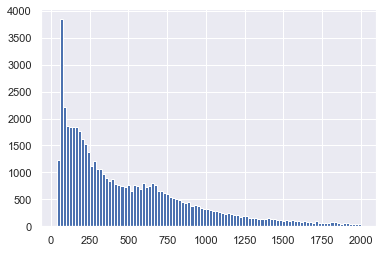

In [41]:
final.to_pandas()['len'].hist(bins=100)

In [3]:
temp = ds.filter(lambda x: x['len'] <= 1000)
t = temp.shuffle()[0]
print(t['input'] + t['output'])

NameError: name 'ds' is not defined

array([[<AxesSubplot:title={'center':'len'}>]], dtype=object)

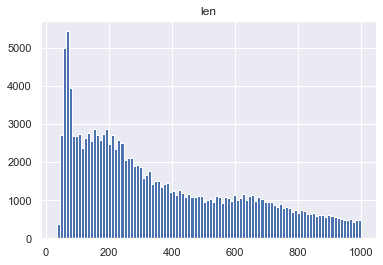

In [155]:
temp.to_pandas().hist(column='len', bins=100)

In [154]:
temp.shuffle().select(range(60000)).to_json('../../../data/training_21_8/mix_60k.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/60 [00:00<?, ?ba/s]

175117071

In [136]:
temp = ds.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Dựa trên các định luật cơ bản của cơ học cổ điển, hành vi của một quả bóng được ném lên bầu khí quyển có thể được mô tả bằng toán học theo quỹ đạo mà nó đi theo? Để trả lời câu hỏi này, người ta phải xem xét các yếu tố khác nhau có thể ảnh hưởng đến chuyển động của quả bóng, chẳng hạn như lực cản không khí, lực hấp dẫn và vận tốc ban đầu, sau đó sử dụng các nguyên tắc khoa học để phân tích và dự đoán quỹ đạo của nó. Bạn có thể đưa ra lời giải thích chi tiết về các hiện tượng vật lý phức tạp chi phối chuyển động của một vật thể trong không khí không?
[|AI|] Chắc chắn rồi! Khi một quả bóng được ném lên bầu khí quyển, nó sẽ chịu một số lực chi phối chuyển động của nó. Lực chính tác dụng lên quả bóng là lực hấp dẫn, lực này kéo quả bóng xuống Trái đất. Ngoài ra, quả bóng chịu sức cản của không khí, là lực chống lại chuyển động của quả bóng khi nó di chuyển trong không khí.
Quỹ đạo mà quả bóng bay theo được xác định bởi vận tốc ban 

<AxesSubplot:>

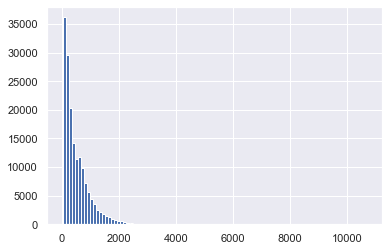

In [74]:
df = ds.to_pandas()
df['len'].hist(bins=100)

In [75]:
df[df['output_len'] <= 50]

,input,output,input_len,output_len,len
4,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Chủ đề của câu hỏi này là máy tính và internet...,75,18,93
19,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,"Từ gốc cho từ ""careful"" là ""care"".\n[|Con người|]",35,19,54
21,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Anh ấy đã đọc nhiều sách và tạp chí trong suốt...,46,22,68
22,Bạn là một trợ lý AI. Cung cấp câu trả lời chi...,"D) trong các nhà máy, cửa hàng và nhà hàng ở H...",393,22,415
23,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,"Vì cuộc họp bắt đầu lúc 3 giờ chiều, xin vui l...",61,23,84
...,...,...,...,...,...
167896,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Cô ấy mở cửa nhanh chóng.\n[|Con người|],45,13,58
167903,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Câu trả lời: Giá trị khuyến nghị hàng ngày đối...,165,30,195
167904,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,"Mặt trời rực rỡ trên bầu trời, nhưng không còn...",54,21,75
167910,Bạn là một trợ lý AI. Người dùng sẽ cung cấp c...,Một số ví dụ về cung điện hoàng gia lớn được x...,257,28,285


In [104]:
temp = df[df['output_len'] <= 40].sample(1)
print(temp['input'].values[0] + temp['output'].values[0])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Phân loại từ loại cho mỗi từ trong câu này: "They have already started their new business".
[|AI|] They: đại từ; have: động từ; already: trạng từ; started: động từ; their: đại từ; new: tính từ; business: danh từ.
[|Con người|]


In [608]:
final_df = df[df['len'] <= 2000].reset_index(drop=True)
final_ds = Dataset.from_pandas(final_df).select_columns(['input', 'output'])
final_ds

Dataset({
    features: ['input', 'output'],
    num_rows: 165499
})

<AxesSubplot:>

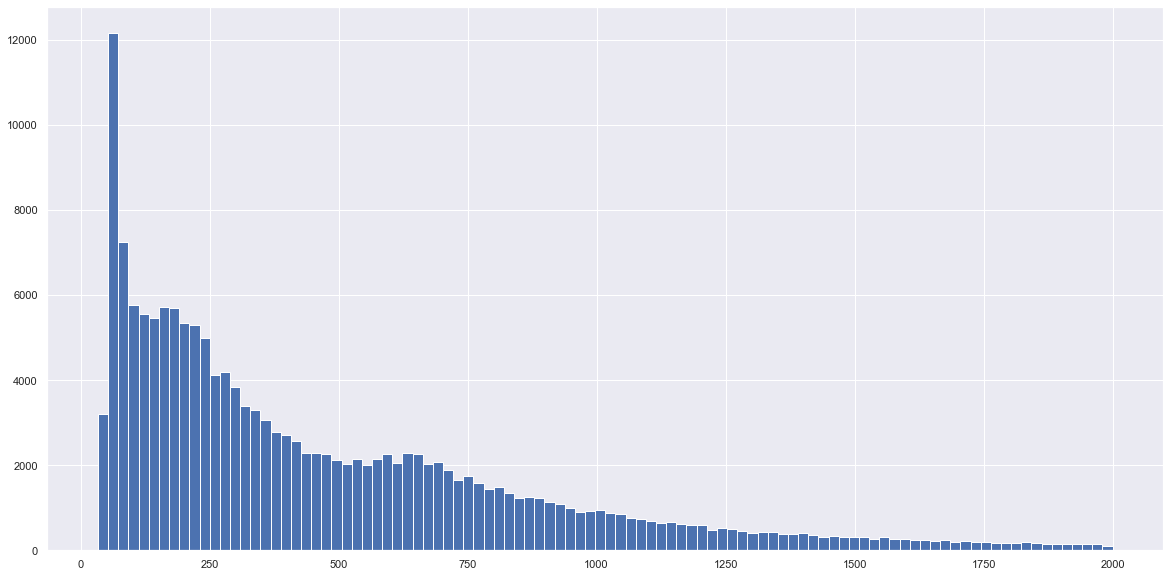

In [611]:
plt.figure(figsize=(20,10))
final_df['len'].hist(bins=100)

In [614]:
final_ds

Dataset({
    features: ['input', 'output'],
    num_rows: 165499
})

In [613]:
final_ds.to_json('../../../data/training_21_8/all_21_8.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/166 [00:00<?, ?ba/s]

626593878

In [596]:
task_oriented = final_ds.shuffle()

In [590]:
instructs = final_ds.shuffle().select(range(40000))

In [597]:
final = concatenate_datasets([task_oriented, instructs]).shuffle()

In [601]:
final.to_json('../../../data/training_21_8/final_51k_25_8_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/52 [00:00<?, ?ba/s]

141731454

In [598]:
final

Dataset({
    features: ['input', 'output', 'len'],
    num_rows: 51014
})

array([[<AxesSubplot:title={'center':'len'}>]], dtype=object)

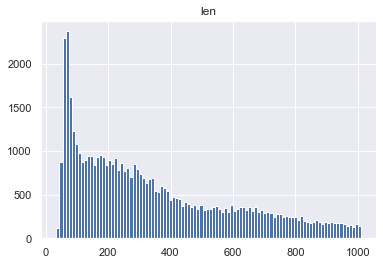

In [600]:
final.to_pandas().hist(column='len', bins=100)

In [36]:
final

NameError: name 'final' is not defined

In [568]:
temp = final.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Sự sửa đổi gần đây được thực hiện đối với lời nhắc đã làm tăng độ phức tạp của nó bằng cách đưa vào cốt truyện nhiều lớp kích thước khác nhau và các thực tại thay thế. Hơn nữa, một tổ chức bí mật và lâu đời với động cơ không rõ ràng đã được thêm vào, làm cho cốt truyện trở nên phức tạp và khó hiểu hơn.
[|AI|] Thật vậy, lời nhắc đã sửa đổi bổ sung thêm một số lớp phức tạp đòi hỏi người viết phải sáng tạo và tư duy phản biện nhiều hơn. Việc bổ sung tổ chức bí mật đã tạo thêm một mức độ hấp dẫn và bí ẩn mới cho câu chuyện, giúp các nhà văn có nhiều cơ hội hơn để khám phá thế giới và các nhân vật mà họ tạo ra. Nó cũng cho phép khám phá các chủ đề như động lực học quyền lực, kiểm soát và đạo đức, mang đến một câu chuyện phong phú và nhiều sắc thái hơn. Nhìn chung, lời nhắc sửa đổi thách thức người viết tạo ra một câu chuyện phức tạp và kích thích tư duy hơn, có thể thu hút và lôi cuốn người đọc.
[|Con người|]


In [16]:
ds = Dataset.from_json('/Users/phamhoang1408/Desktop/Phase 2 Viettel/main_repo/data/training_21_8/all_21_8.jsonl')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /Users/phamhoang1408/.cache/huggingface/datasets/json/default-ca45e27eabe39165/0.0.0. Subsequent calls will reuse this data.


In [17]:
def mapper(x):
    return {
        'input_len': len(tokenizer.encode(x['input'])),
        'output_len': len(tokenizer.encode(x['output']))
    }

ds = ds.map(mapper, batched=False)

Map:   0%|          | 0/165499 [00:00<?, ? examples/s]

In [20]:
ds

Dataset({
    features: ['input', 'output', 'input_len', 'output_len'],
    num_rows: 165499
})

array([[<AxesSubplot:title={'center':'output_len'}>]], dtype=object)

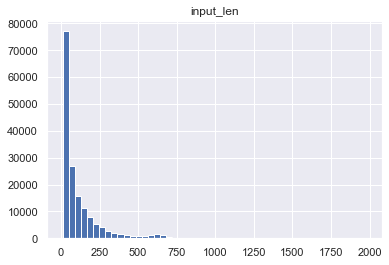

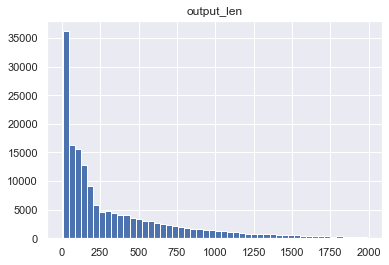

In [21]:
ds.to_pandas().hist(column='input_len', bins=50)
ds.to_pandas().hist(column='output_len', bins=50)

In [24]:
ds.to_pandas()['output_len'].quantile(0.7)

419.0

### Length Distribution

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-dc6d15fb5167c5a8/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-093c0dcfb5399bef/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-1734e637d9ab56af/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-92cf1d228eff0430/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-cad4ee1bb77060a2/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-81112a902fe4e812/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-846a4aab1e1dc6ad/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-9f4d54555791d380/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-9b4fabc

Map:   0%|          | 0/5973 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30527 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset:  code_related_ocapi_6k_samples


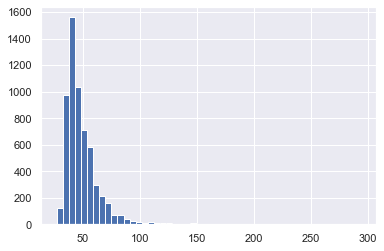

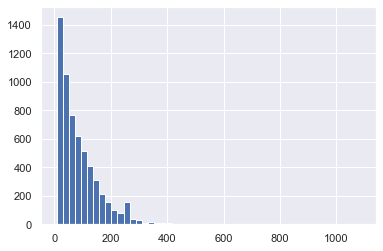

---------------------
Dataset:  dolly_5k_samples


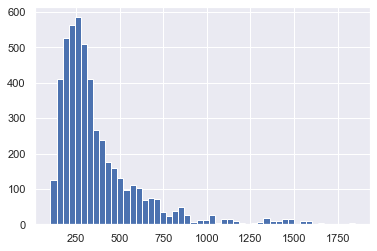

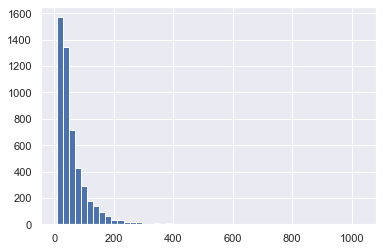

---------------------
Dataset:  faqs_400_samples


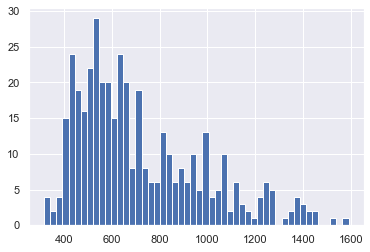

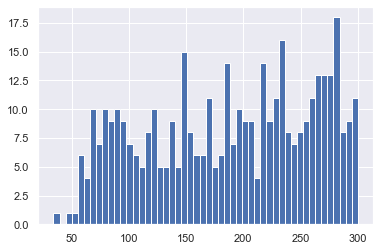

---------------------
Dataset:  gpt4_instruct_10k


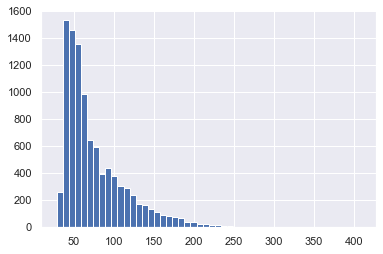

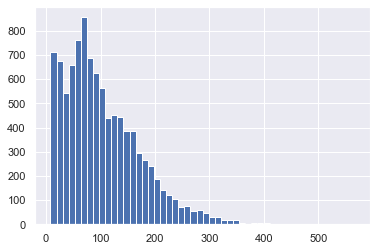

---------------------
Dataset:  no_code_ocapi_30k_samples


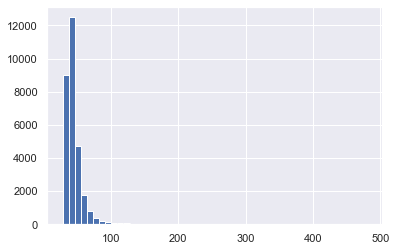

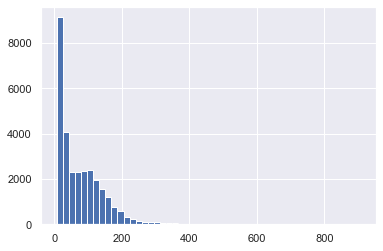

---------------------
Dataset:  query_gen_500_up_samples


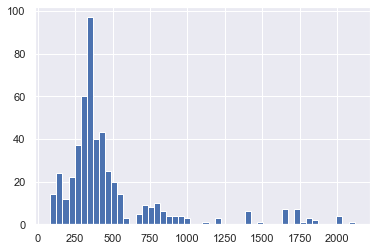

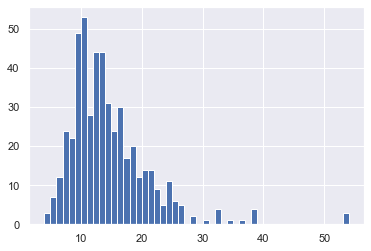

---------------------
Dataset:  orca_25k_samples


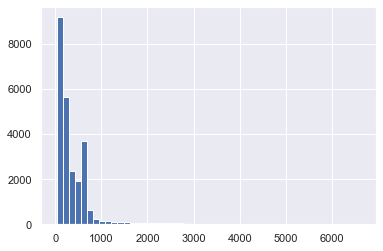

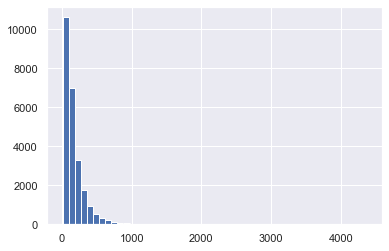

---------------------
Dataset:  role_play_5k_up_samples


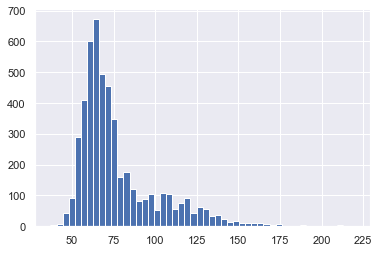

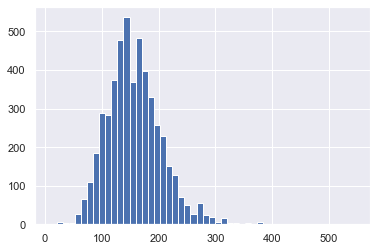

---------------------
Dataset:  squadv2_no_ans_1500_samples


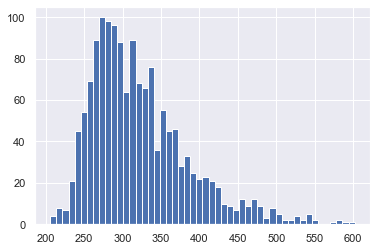

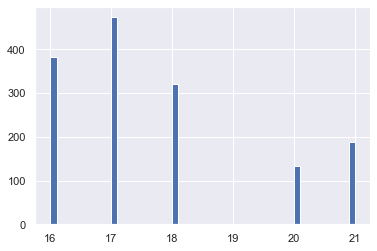

---------------------
Dataset:  topic_classification_4000_samples


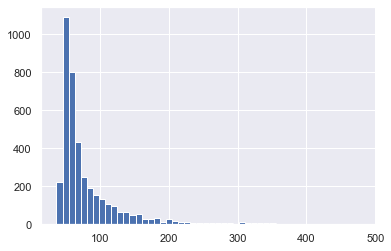

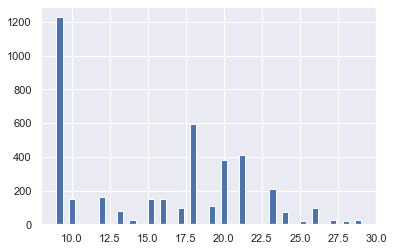

---------------------
Dataset:  wizard_40k_samples


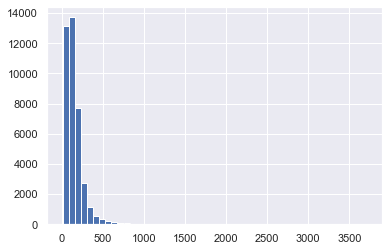

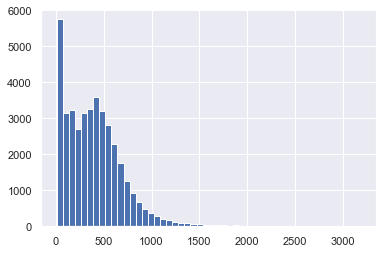

---------------------
Dataset:  wivi_30k_samples


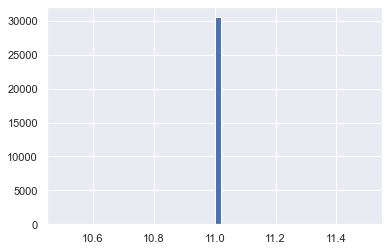

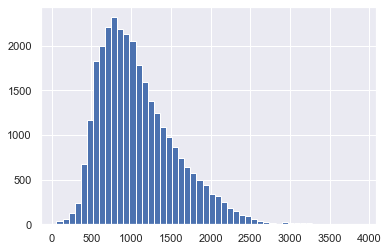

---------------------
Dataset:  quora_5k_samples


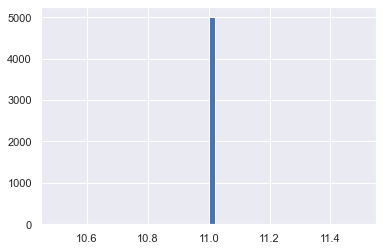

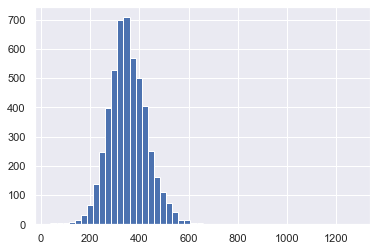

---------------------
Dataset:  oasst_5k_samples


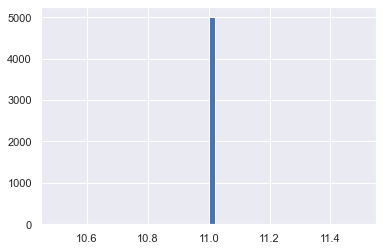

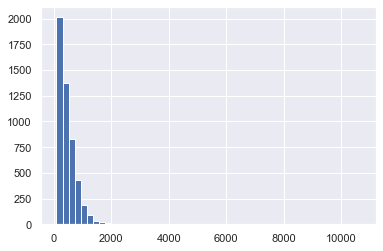

---------------------


In [35]:
root_path = '/Users/phamhoang1408/Desktop/Phase 2 Viettel/main_repo/data/training_21_8/'
dataset_configs = [
    ['code_related_ocapi_6k_samples.jsonl', 'instruct'],
    ['dolly_5k_samples.jsonl', 'instruct'],
    ['faqs_400_samples.jsonl', 'instruct'],
    ['gpt4_instruct_10k.jsonl', 'instruct'],
    ['no_code_ocapi_30k_samples.jsonl', 'instruct'],
    ['query_gen_500_up_samples.jsonl', 'instruct'],
    ['orca_25k_samples.jsonl', 'instruct'],
    ['role_play_5k_up_samples.jsonl', 'instruct'],
    ['squadv2_no_ans_1500_samples.jsonl', 'instruct'],
    ['topic_classification_4000_samples.jsonl', 'instruct'],
    ['wizard_40k_samples.jsonl', 'instruct'],
    ['wivi_30k_samples.jsonl', 'chat'],
    ['quora_5k_samples.jsonl', 'chat'],
    ['oasst_5k_samples.jsonl', 'chat'],
]
def len_analysis(dataset_configs):
    def mapper(x):
        return {
            'input_len': len(tokenizer.encode(x['input'])),
            'output_len': len(tokenizer.encode(x['output']))
        }
    collections = {}
    for ds_config in dataset_configs:
        name = ds_config[0].split('.')[0]
        collections[name] = Dataset.from_json(root_path + ds_config[0])
    for k, v in collections.items():
        collections[k] = v.map(mapper, batched=False, remove_columns=v.column_names)
    for k, v in collections.items():
        print('Dataset: ', k)
        df = v.to_pandas()
        df['input_len'].hist(bins=50)
        plt.show()
        df['output_len'].hist(bins=50)
        plt.show()
        print('---------------------')

len_analysis(dataset_configs)

In [ ]:
DATASET = '/kaggle/input/general-chatbot-5-8/60k_mixed_2.jsonl'
DATASET_FORMAT = 'input-output'
OUTPUT_DIR = './outputs/'

PER_DEVICE_TRAIN_BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 4
LEARNING_RATE = '0.03'
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03

LORA_R = 128
LORA_ALPHA = 32 
LORA_DROPOUT = 0.1

TRAIN_ON_SOURCE = False
SOURCE_MAX_LENGTH = 1024
TARGET_MAX_LENGTH = 1024

LOGGING_STEPS = 20
SAVE_STEPS = 100
SAVE_TOTAL_LIMIT = 4

def check(args):
    assert args.dataset == DATASET
    assert args.dataset_format == DATASET_FORMAT
    assert args.output_dir == OUTPUT_DIR
    assert args.per_device_train_batch_size == PER_DEVICE_TRAIN_BATCH_SIZE
    assert args.gradient_accumulation_steps == GRADIENT_ACCUMULATION_STEPS
    assert args.learning_rate == LEARNING_RATE
    assert args.lr_scheduler_type == LR_SCHEDULER_TYPE
    assert args.warmup_ratio == WARMUP_RATIO
    assert args.lora_r == LORA_R
    assert args.lora_alpha == LORA_ALPHA
    assert args.lora_dropout == LORA_DROPOUT
    assert args.train_on_source == TRAIN_ON_SOURCE
    assert args.source_max_length == SOURCE_MAX_LENGTH
    assert args.target_max_length == TARGET_MAX_LENGTH
    assert args.logging_steps == LOGGING_STEPS
    assert args.save_steps == SAVE_STEPS
    assert args.save_total_limit == SAVE_TOTAL_LIMIT
